IMDb Movie Rating Prediction Analysis

In [3]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Data Loading and Initial Exploration

In [5]:
# Load the dataset
df = pd.read_csv('IMDb Movies India.csv', encoding='ISO-8859-1')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (15509, 10)

First few rows:
                                 Name    Year Duration            Genre  \
0                                         NaN      NaN            Drama   
1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min            Drama   
2                         #Homecoming  (2021)   90 min   Drama, Musical   
3                             #Yaaram  (2019)  110 min  Comedy, Romance   
4                   ...And Once Again  (2010)  105 min            Drama   

   Rating Votes            Director       Actor 1             Actor 2  \
0     NaN   NaN       J.S. Randhawa      Manmauji              Birbal   
1     7.0     8       Gaurav Bakshi  Rasika Dugal      Vivek Ghamande   
2     NaN   NaN  Soumyajit Majumdar  Sayani Gupta   Plabita Borthakur   
3     4.4    35          Ovais Khan       Prateik          Ishita Raj   
4     NaN   NaN        Amol Palekar  Rajat Kapoor  Rituparna Sengupta   

           Actor 3  
0  Rajendra Bhatia  
1    Arvind Jangid  
2  

Data Cleaning and Preprocessing

In [10]:
# Data Cleaning and Preprocessing
def clean_data(df):
    # Create a copy
    df_clean = df.copy()
    
    # Drop rows with completely empty data
    df_clean = df_clean.dropna(how='all')
    
    # Clean Year column - extract year from strings like '(2019)'
    if 'Year' in df_clean.columns:
        df_clean['Year'] = df_clean['Year'].astype(str).str.extract(r'(\d{4})').astype(float)
    
    # Clean Duration column - extract minutes
    if 'Duration' in df_clean.columns:
        df_clean['Duration'] = df_clean['Duration'].astype(str).str.extract(r'(\d+)').astype(float)
    
    # Clean Votes column - remove commas, $, M, etc.
    if 'Votes' in df_clean.columns:
        df_clean['Votes'] = (
            df_clean['Votes']
            .astype(str)
            .str.replace('[^0-9]', '', regex=True)  # keep only digits
        )
        df_clean['Votes'] = pd.to_numeric(df_clean['Votes'], errors='coerce')
    
    # Clean Rating column - ensure it's numeric
    if 'Rating' in df_clean.columns:
        df_clean['Rating'] = pd.to_numeric(df_clean['Rating'], errors='coerce')
    
    # Handle missing values
    for col in ['Year', 'Duration', 'Votes']:
        if col in df_clean.columns:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    # Fill missing genres with 'Unknown'
    if 'Genre' in df_clean.columns:
        df_clean['Genre'].fillna('Unknown', inplace=True)
    
    # Fill missing director and actors with 'Unknown'
    for col in ['Director', 'Actor 1', 'Actor 2', 'Actor 3']:
        if col in df_clean.columns:
            df_clean[col].fillna('Unknown', inplace=True)
    
    # Drop rows with missing ratings (our target variable)
    if 'Rating' in df_clean.columns:
        df_clean = df_clean.dropna(subset=['Rating'])
    
    return df_clean

# Clean the dataset
df_clean = clean_data(df)
print(f"Dataset after cleaning: {df_clean.shape}")


Dataset after cleaning: (7919, 10)


Feature Engineering

In [11]:
# Feature Engineering
def engineer_features(df):
    df_fe = df.copy()
    
    # Create decade feature
    df_fe['Decade'] = (df_fe['Year'] // 10) * 10
    
    # Create genre count feature
    df_fe['Genre_Count'] = df_fe['Genre'].apply(lambda x: len(str(x).split(',')))
    
    # Create director experience (number of movies)
    director_counts = df_fe['Director'].value_counts()
    df_fe['Director_Exp'] = df_fe['Director'].map(director_counts)
    
    # Create actor popularity features
    all_actors = pd.concat([df_fe['Actor 1'], df_fe['Actor 2'], df_fe['Actor 3']])
    actor_counts = all_actors.value_counts()
    
    df_fe['Actor1_Popularity'] = df_fe['Actor 1'].map(actor_counts)
    df_fe['Actor2_Popularity'] = df_fe['Actor 2'].map(actor_counts)
    df_fe['Actor3_Popularity'] = df_fe['Actor 3'].map(actor_counts)
    
    # Fill NaN values for actors not in the dataset
    df_fe['Actor1_Popularity'].fillna(0, inplace=True)
    df_fe['Actor2_Popularity'].fillna(0, inplace=True)
    df_fe['Actor3_Popularity'].fillna(0, inplace=True)
    
    # Create total actor popularity
    df_fe['Total_Actor_Popularity'] = df_fe['Actor1_Popularity'] + df_fe['Actor2_Popularity'] + df_fe['Actor3_Popularity']
    
    # Create has votes feature
    df_fe['Has_Votes'] = df_fe['Votes'].apply(lambda x: 1 if x > 0 else 0)
    
    return df_fe

# Engineer features
df_fe = engineer_features(df_clean)
print(f"Dataset after feature engineering: {df_fe.shape}")

Dataset after feature engineering: (7919, 18)


Exploratory Data Analysis (EDA)

=== EXPLORATORY DATA ANALYSIS ===


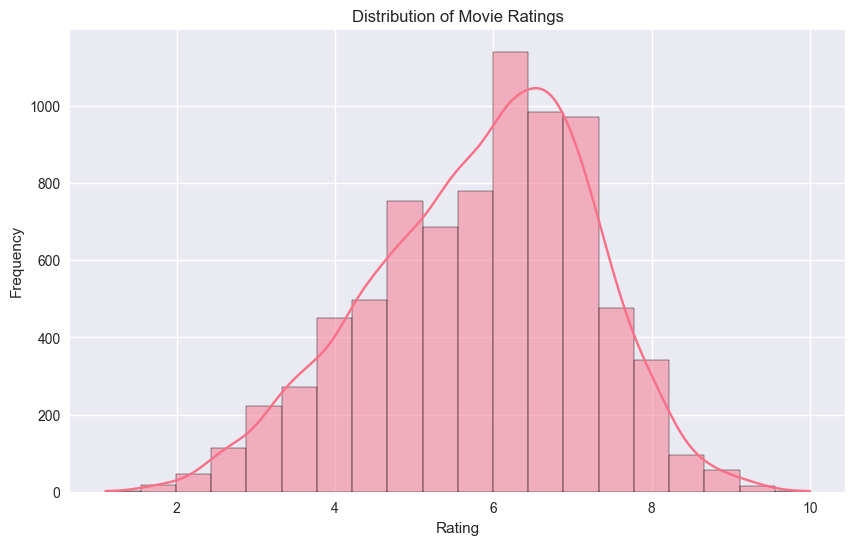

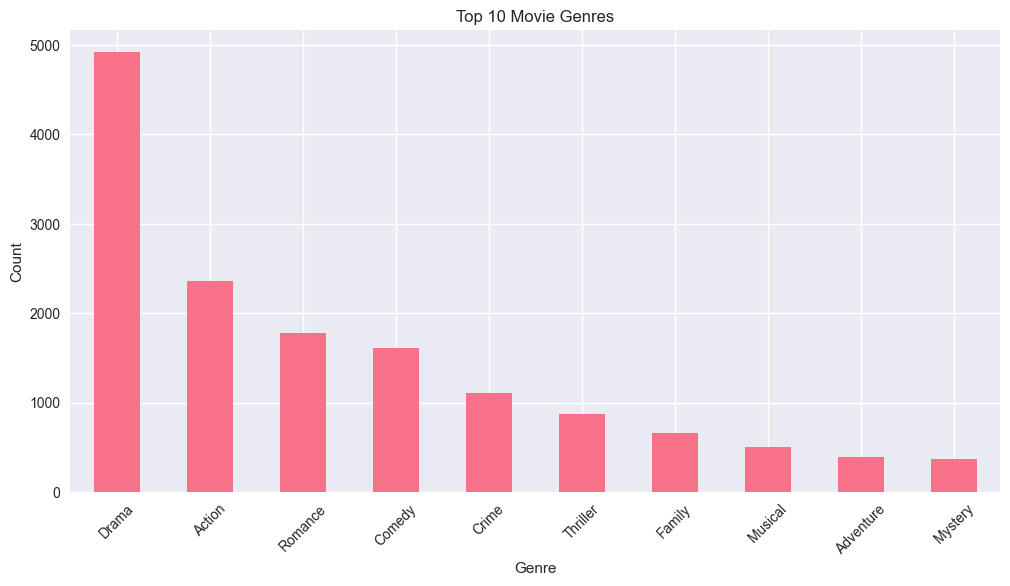

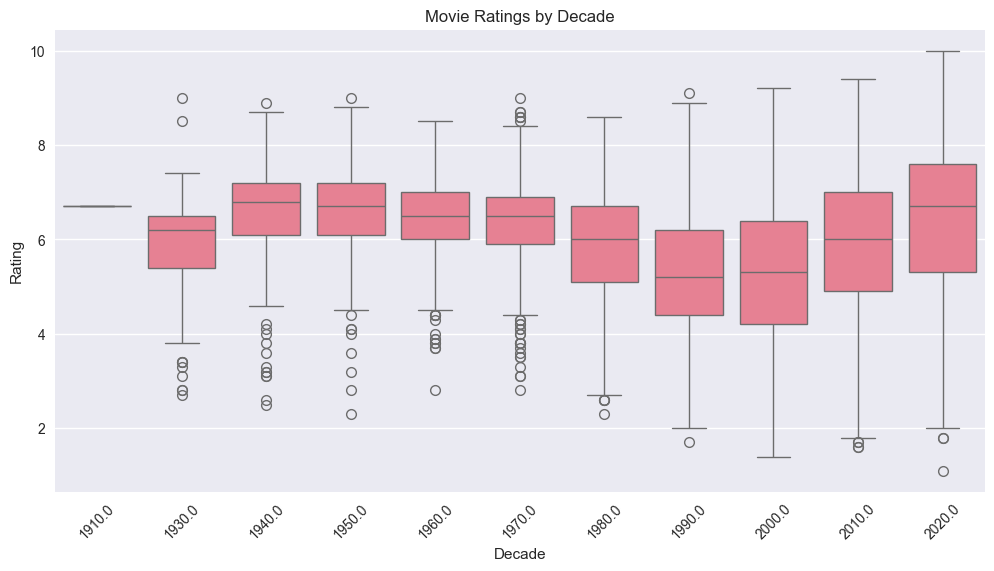

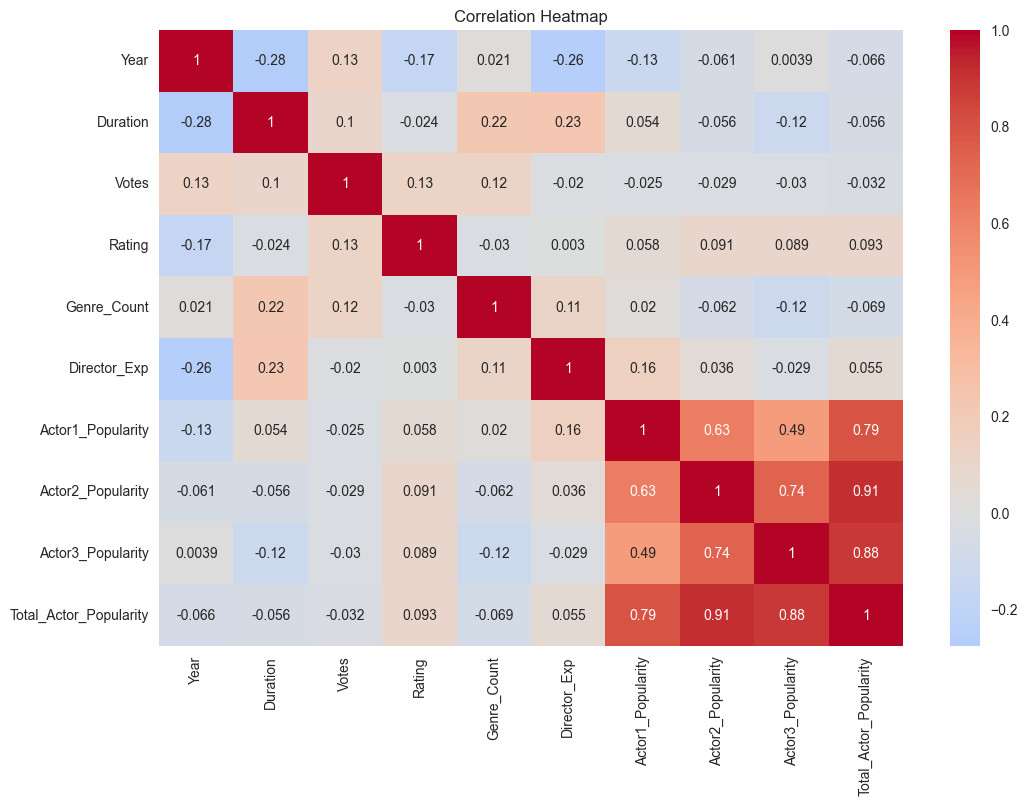

In [12]:
# Exploratory Data Analysis
def perform_eda(df):
    print("=== EXPLORATORY DATA ANALYSIS ===")
    
    # Rating distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Rating'], bins=20, kde=True)
    plt.title('Distribution of Movie Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.show()
    
    # Top genres
    all_genres = []
    for genres in df['Genre'].str.split(','):
        if isinstance(genres, list):
            all_genres.extend([g.strip() for g in genres])
    
    genre_counts = pd.Series(all_genres).value_counts().head(10)
    
    plt.figure(figsize=(12, 6))
    genre_counts.plot(kind='bar')
    plt.title('Top 10 Movie Genres')
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    
    # Rating by decade
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Decade', y='Rating', data=df)
    plt.title('Movie Ratings by Decade')
    plt.xlabel('Decade')
    plt.ylabel('Rating')
    plt.xticks(rotation=45)
    plt.show()
    
    # Correlation heatmap
    numeric_cols = ['Year', 'Duration', 'Votes', 'Rating', 'Genre_Count', 
                   'Director_Exp', 'Actor1_Popularity', 'Actor2_Popularity', 
                   'Actor3_Popularity', 'Total_Actor_Popularity']
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.show()

# Perform EDA
perform_eda(df_fe)

Model Building and Evaluation

Training set: (6335, 11), Test set: (1584, 11)
Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training Random Forest...
Training Gradient Boosting...
Training Support Vector Regression...

=== MODEL PERFORMANCE COMPARISON ===
                       Model  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  \
0          Linear Regression      1.3407     1.3007     1.0705    1.0387   
1           Ridge Regression      1.3407     1.3007     1.0705    1.0387   
2           Lasso Regression      1.3587     1.3342     1.0966    1.0758   
3              Random Forest      0.4314     1.1214     0.3241    0.8509   
4          Gradient Boosting      1.0695     1.1062     0.8196    0.8361   
5  Support Vector Regression      1.1746     1.1647     0.8907    0.8983   

   Train_R2  Test_R2  CV_R2_Mean  
0    0.0643   0.0899      0.0493  
1    0.0643   0.0899      0.0493  
2    0.0391   0.0425      0.0372  
3    0.9031   0.3236      0.3167  
4    0.4046   0.3418     

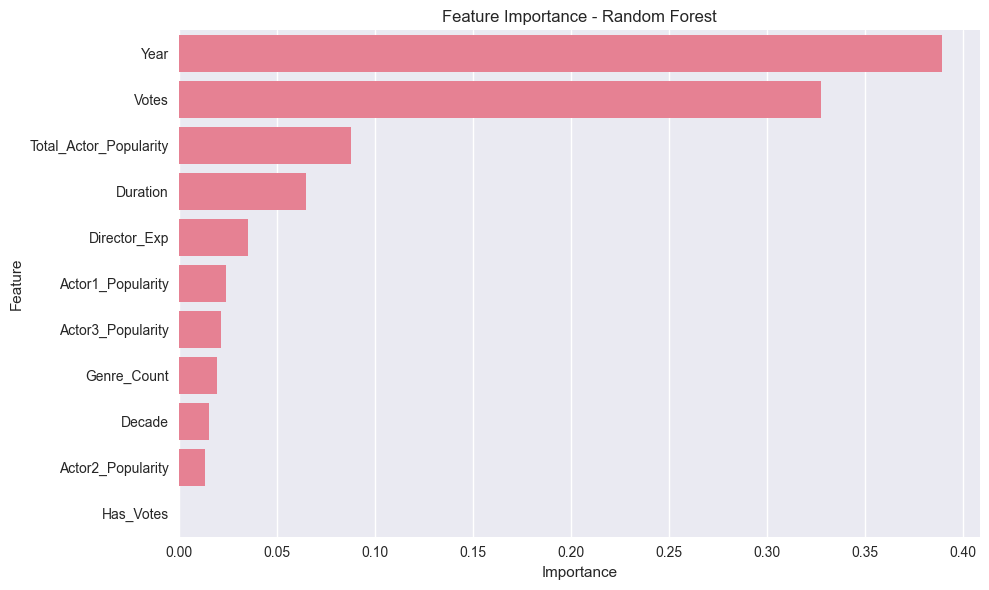

In [13]:
# Prepare data for modeling
def prepare_data(df):
    # Select features for modeling
    features = ['Year', 'Duration', 'Votes', 'Genre_Count', 'Director_Exp', 
               'Actor1_Popularity', 'Actor2_Popularity', 'Actor3_Popularity',
               'Total_Actor_Popularity', 'Has_Votes', 'Decade']
    
    X = df[features]
    y = df['Rating']
    
    return X, y

X, y = prepare_data(df_fe)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Building and Evaluation
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_mean = cv_scores.mean()
    
    # Create a results dataframe
    results = pd.DataFrame({
        'Model': [model_name],
        'Train_RMSE': [train_rmse],
        'Test_RMSE': [test_rmse],
        'Train_MAE': [train_mae],
        'Test_MAE': [test_mae],
        'Train_R2': [train_r2],
        'Test_R2': [test_r2],
        'CV_R2_Mean': [cv_mean]
    })
    
    return results, model, y_pred_test

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf', C=1.0, gamma='scale')
}

# Evaluate all models
results_list = []
best_model = None
best_test_r2 = -np.inf
predictions = {}

for name, model in models.items():
    print(f"Training {name}...")
    result, trained_model, y_pred = evaluate_model(
        model, X_train_scaled, X_test_scaled, y_train, y_test, name
    )
    results_list.append(result)
    
    predictions[name] = y_pred
    
    if result['Test_R2'].values[0] > best_test_r2:
        best_test_r2 = result['Test_R2'].values[0]
        best_model = trained_model

# Combine all results
results_df = pd.concat(results_list, ignore_index=True)
print("\n=== MODEL PERFORMANCE COMPARISON ===")
print(results_df.round(4))

# Feature Importance for the best model
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance - Random Forest')
    plt.tight_layout()
    plt.show()

Hyperparameter Tuning

In [14]:
# Hyperparameter Tuning for the best model
def tune_hyperparameters(model, param_grid, X, y):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X, y)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

# Tune Random Forest if it's the best model
if isinstance(best_model, RandomForestRegressor):
    print("\n=== HYPERPARAMETER TUNING FOR RANDOM FOREST ===")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    tuned_rf = tune_hyperparameters(
        RandomForestRegressor(random_state=42),
        param_grid,
        X_train_scaled,
        y_train
    )
    
    # Evaluate tuned model
    tuned_results, _, _ = evaluate_model(
        tuned_rf, X_train_scaled, X_test_scaled, y_train, y_test, 'Tuned Random Forest'
    )
    results_df = pd.concat([results_df, tuned_results], ignore_index=True)
    best_model = tuned_rf

Results Visualization and Analysis

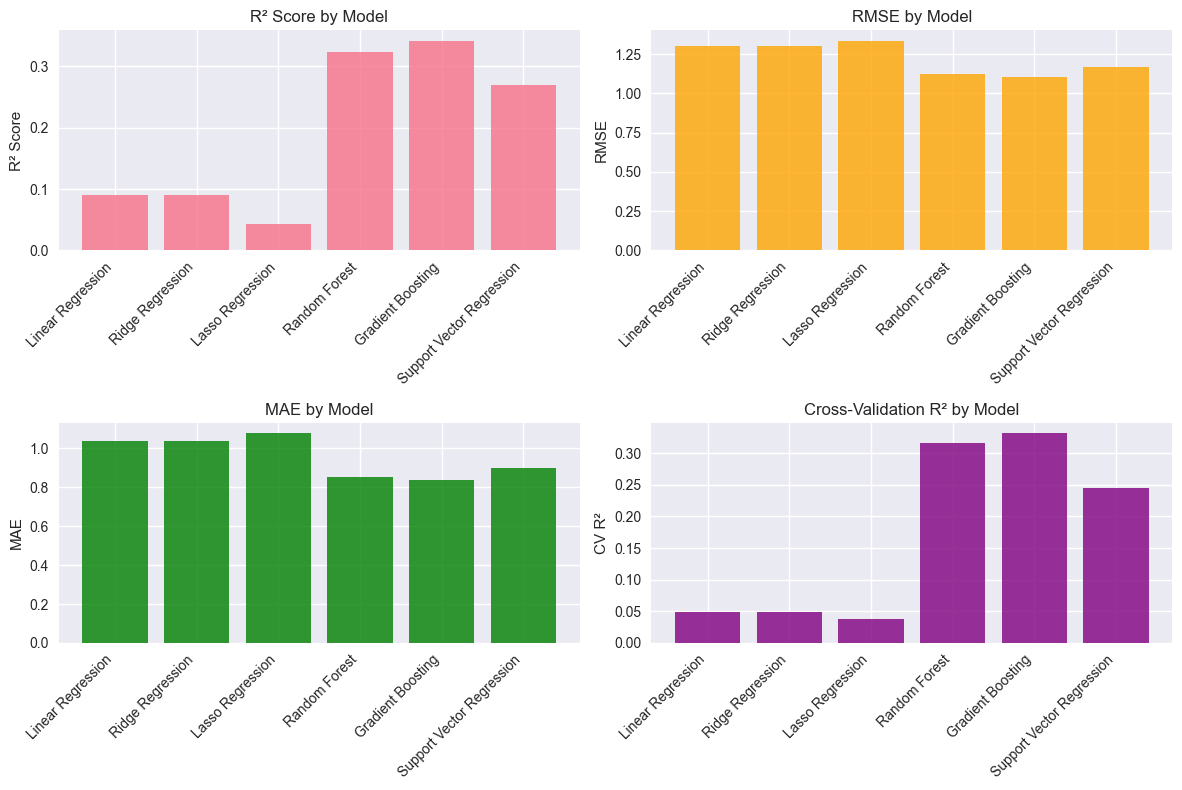

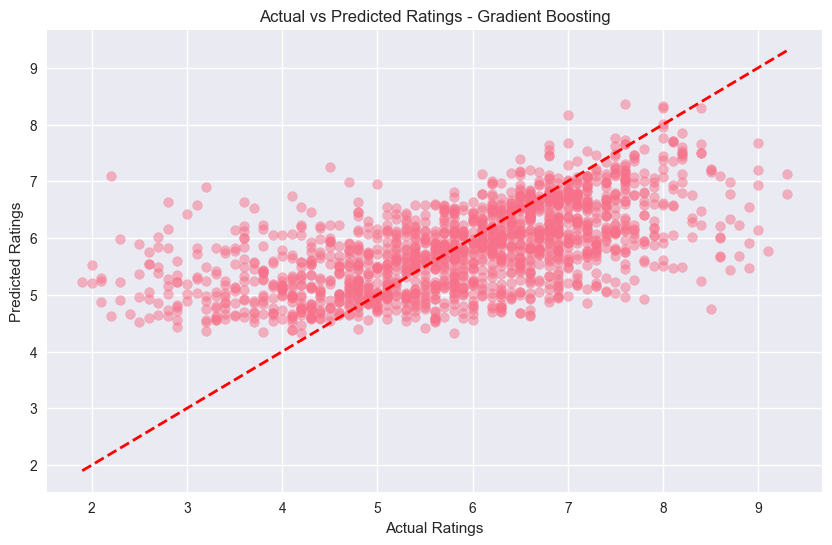

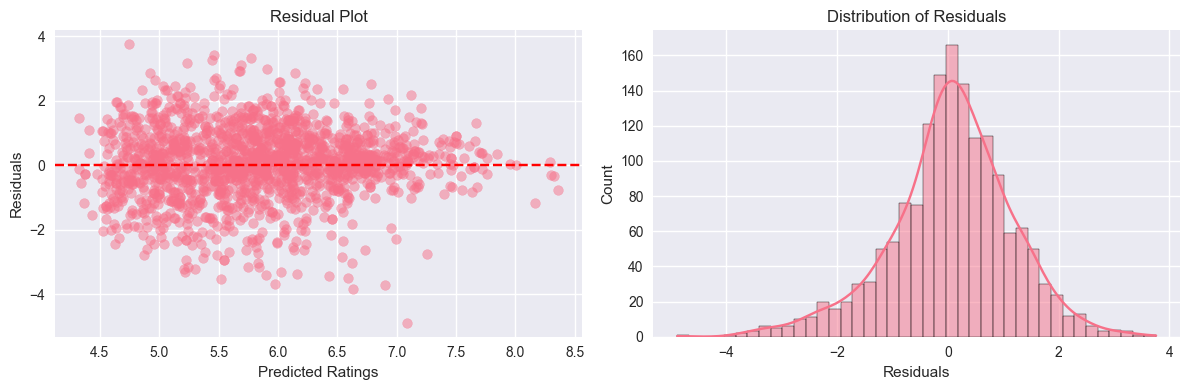

In [15]:
# Final evaluation visualization
plt.figure(figsize=(12, 8))
models_list = results_df['Model'].values
x_pos = np.arange(len(models_list))

plt.subplot(2, 2, 1)
plt.bar(x_pos, results_df['Test_R2'], alpha=0.8)
plt.xticks(x_pos, models_list, rotation=45, ha='right')
plt.title('R² Score by Model')
plt.ylabel('R² Score')

plt.subplot(2, 2, 2)
plt.bar(x_pos, results_df['Test_RMSE'], alpha=0.8, color='orange')
plt.xticks(x_pos, models_list, rotation=45, ha='right')
plt.title('RMSE by Model')
plt.ylabel('RMSE')

plt.subplot(2, 2, 3)
plt.bar(x_pos, results_df['Test_MAE'], alpha=0.8, color='green')
plt.xticks(x_pos, models_list, rotation=45, ha='right')
plt.title('MAE by Model')
plt.ylabel('MAE')

plt.subplot(2, 2, 4)
plt.bar(x_pos, results_df['CV_R2_Mean'], alpha=0.8, color='purple')
plt.xticks(x_pos, models_list, rotation=45, ha='right')
plt.title('Cross-Validation R² by Model')
plt.ylabel('CV R²')

plt.tight_layout()
plt.show()

# Actual vs Predicted for the best model
best_model_name = results_df.loc[results_df['Test_R2'].idxmax(), 'Model']
y_pred_best = predictions.get(best_model_name, best_model.predict(X_test_scaled))

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title(f'Actual vs Predicted Ratings - {best_model_name}')
plt.show()

# Residual analysis
residuals = y_test - y_pred_best

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')

plt.tight_layout()
plt.show()

Making Predictions and Saving the Model

In [16]:
# Prediction function for new movies
def predict_movie_rating(model, scaler, df, director, actor1, actor2, actor3, 
                        genre, year, duration, votes=None):
    # Prepare features
    features = ['Year', 'Duration', 'Votes', 'Genre_Count', 'Director_Exp', 
               'Actor1_Popularity', 'Actor2_Popularity', 'Actor3_Popularity',
               'Total_Actor_Popularity', 'Has_Votes', 'Decade']
    
    # Calculate director experience
    director_exp = df['Director'].value_counts().get(director, 1)
    
    # Calculate actor popularity
    all_actors = pd.concat([df['Actor 1'], df['Actor 2'], df['Actor 3']])
    actor_counts = all_actors.value_counts()
    
    actor1_pop = actor_counts.get(actor1, 0)
    actor2_pop = actor_counts.get(actor2, 0)
    actor3_pop = actor_counts.get(actor3, 0)
    total_actor_pop = actor1_pop + actor2_pop + actor3_pop
    
    # Genre count
    genre_count = len(genre.split(',')) if isinstance(genre, str) else 1
    
    # Has votes
    has_votes = 1 if votes and votes > 0 else 0
    
    # Decade
    decade = (year // 10) * 10
    
    # Default votes if not provided
    if votes is None:
        votes = df['Votes'].median()
    
    # Create feature array
    movie_features = np.array([[
        year, duration, votes, genre_count, director_exp,
        actor1_pop, actor2_pop, actor3_pop, total_actor_pop,
        has_votes, decade
    ]])
    
    # Scale features
    movie_features_scaled = scaler.transform(movie_features)
    
    # Predict rating
    predicted_rating = model.predict(movie_features_scaled)[0]
    
    return max(0, min(10, predicted_rating))  # Ensure rating is between 0 and 10

# Example prediction
example_rating = predict_movie_rating(
    best_model, scaler, df_fe,
    director='Rajkumar Hirani',
    actor1='Aamir Khan',
    actor2='Madhavan',
    actor3='Mona Singh',
    genre='Comedy, Drama',
    year=2009,
    duration=170,
    votes=357889
)

print(f"\nPredicted rating for example movie: {example_rating:.2f}")

# Save the best model
import joblib
joblib.dump(best_model, 'movie_rating_predictor.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
print("\nModel saved as 'movie_rating_predictor.pkl'")


Predicted rating for example movie: 7.66

Model saved as 'movie_rating_predictor.pkl'
